## Step 1: Data Preparation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms,datasets
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import average_precision_score
import random
from PIL import Image, ImageEnhance
from torch.utils.data import DataLoader, random_split
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [7]:
base_folder_path = '/kaggle/input/dataset/Data'

In [8]:
# Set seed for reproducibility
random.seed(42)
torch.manual_seed(42)

class GeneralTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, img):
        return self.transforms(img)

class BicycleTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, img):
        img = ImageEnhance.Color(img).enhance(1.5)  # Boost color saturation for bicycle images
        return self.transforms(img)

In [9]:
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        self.class_to_transform = {
            'Bicycle_rider': transform_bicycle,
            'E-scooter_rider': transform_general,
            'Pedestrian': transform_general
        }

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)  # Get the image and label
        class_name = self.classes[label]  # Get the class name from the label

        # Apply the specific transformation based on the class
        if class_name in self.class_to_transform:
            transform = self.class_to_transform[class_name]
            img = transform(img)  # Apply the class-specific transform

        return img, label  # Return the transformed image and label

In [10]:
# Instantiate the transformations
transform_general = GeneralTransform()
transform_bicycle = BicycleTransform()

# Define dataset without any transform
dataset = CustomImageFolder(root=base_folder_path, transform=None)

In [11]:
# Split the dataset into train, validation, and test sets
total_images = len(dataset)
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)
test_size = total_images - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
# Create DataLoaders for train, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset size info
print(f"Total images: {total_images}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Total images: 32193
Training set size: 22535
Validation set size: 4828
Test set size: 4830


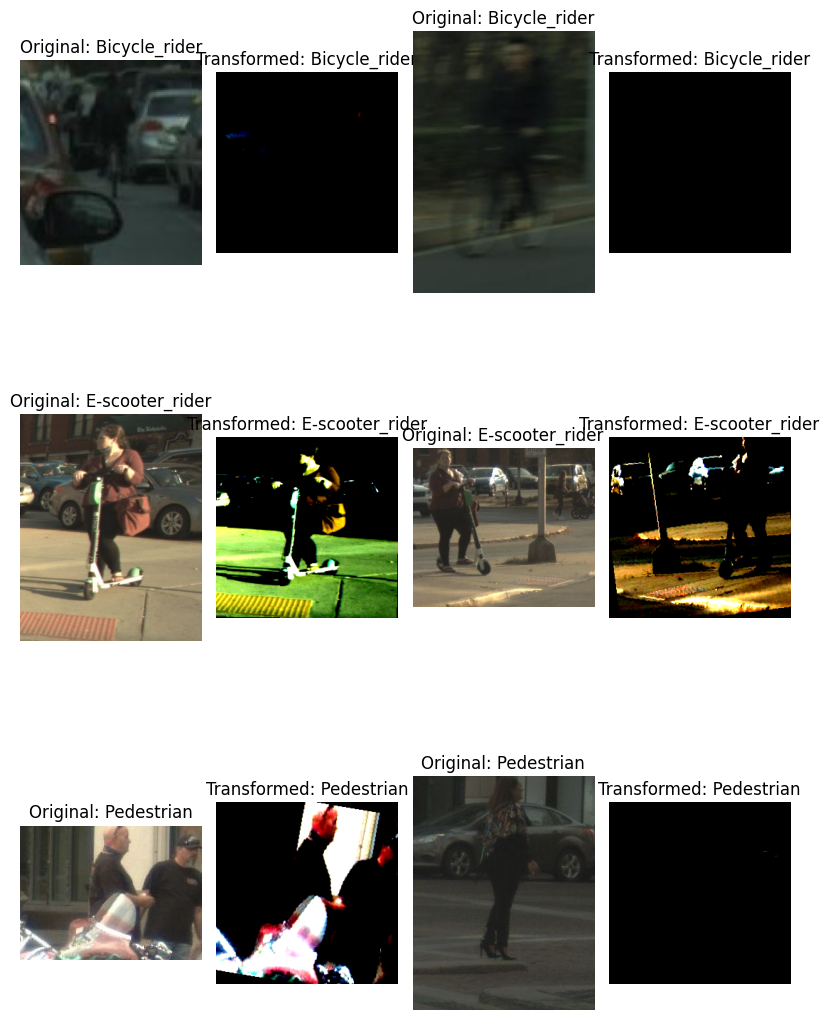

In [13]:
# Function to display a sample of images from each class
def show_sample_images_by_class(dataset, class_names, num_samples=2):
    fig, axs = plt.subplots(len(class_names), num_samples * 2, figsize=(num_samples * 4, len(class_names) * 4))
    class_counts = {name: 0 for name in class_names}  # To track number of images displayed per class

    for idx in range(len(dataset)):
        if all(count >= num_samples for count in class_counts.values()):
            break  # Stop if we have enough samples for all classes

        original_image, label = dataset[idx]
        class_name = dataset.dataset.classes[label]

        if class_name in class_counts and class_counts[class_name] < num_samples:
            # Access the original image path
            path = dataset.dataset.samples[dataset.indices[idx]][0]
            original_image_pil = Image.open(path)

            # Get the appropriate transformation for the class
            transformed_image = dataset.dataset.class_to_transform[class_name](original_image_pil)

            # Display the original image
            col = class_counts[class_name] * 2
            axs[class_names.index(class_name), col].imshow(original_image_pil)
            axs[class_names.index(class_name), col].set_title(f"Original: {class_name}")
            axs[class_names.index(class_name), col].axis('off')

            # Display the transformed image
            axs[class_names.index(class_name), col + 1].imshow(transformed_image.permute(1, 2, 0).clamp(0, 1))
            axs[class_names.index(class_name), col + 1].set_title(f"Transformed: {class_name}")
            axs[class_names.index(class_name), col + 1].axis('off')

            # Increment the count for the class
            class_counts[class_name] += 1

    plt.tight_layout()
    plt.show()

# List of class names
class_names = ['Bicycle_rider', 'E-scooter_rider', 'Pedestrian']

# Display sample images
show_sample_images_by_class(train_dataset, class_names, num_samples=2)

## Step 2: Model Selection, Training and Validation

In [9]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer to include dropout with less than 20% rate
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.15),  # 15% dropout rate
    nn.Linear(num_features, 3)
)

# Phase 1: Initial training with frozen layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last block and the fully connected layer
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Define criterion and optimizer for phase 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Step learning rate scheduler to adjust the learning rate over epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


In [10]:
# Function to train and validate the model
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Metrics
    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []

    # Time tracking
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        epoch_start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            total_steps = len(train_loader) if phase == 'train' else len(val_loader)
            epoch_preds = []
            epoch_labels = []

            # Iterate over data.
            data_loader = train_loader if phase == 'train' else val_loader
            for step, (inputs, labels) in enumerate(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_labels.extend(labels.cpu().numpy())

                if step % 100 == 0:  # Print stats every 100 steps
                    step_time = time.time() - epoch_start_time
                    processed_samples = (step + 1) * data_loader.batch_size
                    processed_samples = min(processed_samples, len(data_loader.dataset))  # Ensure not exceeding dataset size
                    print(f'Epoch {epoch+1}, Step {step}/{total_steps}, '
                          f'Time/Step: {step_time/100:.2f}s, '
                          f'Loss: {loss.item():.4f}, '
                          f'Accuracy: {running_corrects.double() / processed_samples:.4f}')

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            # Store metrics for plotting
            if phase == 'train':
                all_train_loss.append(epoch_loss)
                all_train_acc.append(epoch_acc)
            else:
                all_val_loss.append(epoch_loss)
                all_val_acc.append(epoch_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

            # Step learning rate scheduler
            if phase == 'train':
                scheduler.step()

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_duration = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1} completed in {epoch_duration:.0f} seconds.')

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    print(f'Total Training Time: {time.time() - start_time:.0f} seconds')

    # Restore best model weights
    model.load_state_dict(best_model_wts)

    # Return trained model and metrics
    return model, all_train_loss, all_val_loss, all_train_acc, all_val_acc


In [11]:
# Phase 1 Training (Initial Training)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model, train_losses, val_losses, train_accs, val_accs = train_and_validate_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10  # Phase 1: 10 epochs
)

Epoch 1/10
----------
Epoch 1, Step 0/705, Time/Step: 0.01s, Loss: 1.6241, Accuracy: 0.2812
Epoch 1, Step 100/705, Time/Step: 0.46s, Loss: 0.1987, Accuracy: 0.8871
Epoch 1, Step 200/705, Time/Step: 0.92s, Loss: 0.0946, Accuracy: 0.9084
Epoch 1, Step 300/705, Time/Step: 1.38s, Loss: 0.1204, Accuracy: 0.9203
Epoch 1, Step 400/705, Time/Step: 1.83s, Loss: 0.0324, Accuracy: 0.9284
Epoch 1, Step 500/705, Time/Step: 2.29s, Loss: 0.3076, Accuracy: 0.9351
Epoch 1, Step 600/705, Time/Step: 2.74s, Loss: 0.0422, Accuracy: 0.9377
Epoch 1, Step 700/705, Time/Step: 3.18s, Loss: 0.0782, Accuracy: 0.9406
Train Loss: 0.1569 Accuracy: 0.9408
Epoch 1, Step 0/151, Time/Step: 3.20s, Loss: 0.0541, Accuracy: 0.9688
Epoch 1, Step 100/151, Time/Step: 3.64s, Loss: 0.0386, Accuracy: 0.9700
Val Loss: 0.0729 Accuracy: 0.9704
Epoch 1 completed in 386 seconds.
Epoch 2/10
----------
Epoch 2, Step 0/705, Time/Step: 0.00s, Loss: 0.0573, Accuracy: 1.0000
Epoch 2, Step 100/705, Time/Step: 0.38s, Loss: 0.0325, Accuracy: 0

In [12]:
# Save the best model
torch.save(model.state_dict(), 'trained_resnet18.pth')

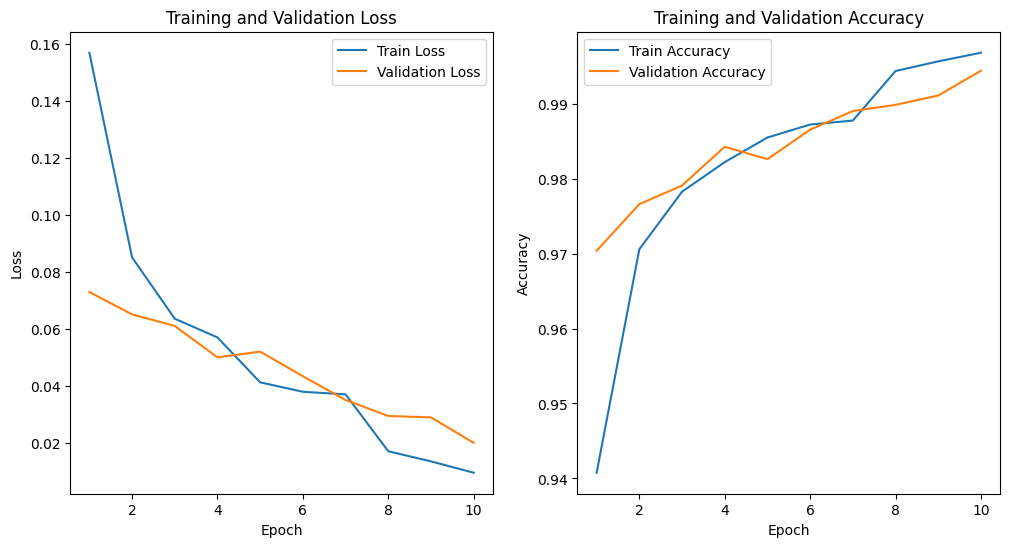

In [13]:
# Plot Training/Validation Loss and Accuracy
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    # Convert any CUDA tensors to CPU floats
    train_accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accs]
    val_accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in val_accs]

    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [5]:
def compute_roc_auc(model, test_loader, device, num_classes=3):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_labels.extend(labels.cpu().numpy())
            all_scores.append(outputs.cpu().numpy())  # Store class probabilities

    all_scores = np.concatenate(all_scores, axis=0)
    all_labels = np.array(all_labels)

    # Binarize the labels for multiclass ROC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} ROC curve (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multiclass')
    plt.legend(loc='lower right')
    plt.show()

    return fpr, tpr, roc_auc

# Function to compute Confusion Matrix, Precision, Recall, and Accuracy
def compute_classification_metrics(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f'Confusion Matrix:\n{cm}')

    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pedestrian', 'Bicycle', 'E-scooter'], yticklabels=['Pedestrian', 'Bicycle', 'E-scooter'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Accuracy, Precision, Recall, and F1-Score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall

# Function to compute mAP (Mean Average Precision)
def compute_map(model, test_loader, device, num_classes=3):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            all_labels.extend(labels.cpu().numpy())
            all_scores.append(outputs.cpu().numpy())  # Store class probabilities

    all_scores = np.concatenate(all_scores, axis=0)

    # Compute Average Precision for each class
    aps = []
    for i in range(num_classes):
        true_labels = np.array([1 if label == i else 0 for label in all_labels])
        class_scores = all_scores[:, i]
        aps.append(average_precision_score(true_labels, class_scores))

    map_score = np.mean(aps)

    return map_score

# Function to run testing, plot metrics, and compute all necessary stats
def test_model(model, test_loader, device):
    print('Testing model...')

    # ROC Curve and AUC
    print('Computing ROC Curve and AUC...')
    fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, device)

    # Confusion Matrix, Precision, Recall, and Accuracy
    print('Computing Classification Metrics (Accuracy, Precision, Recall, Confusion Matrix)...')
    accuracy, precision, recall = compute_classification_metrics(model, test_loader, device)

    # Mean Average Precision (mAP)
    print('Computing Mean Average Precision (mAP)...')
    map_score = compute_map(model, test_loader, device)

    # Summary of the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision (weighted): {precision:.4f}')
    print(f'Recall (weighted): {recall:.4f}')
    print(f'Mean Average Precision (mAP): {map_score:.4f}')

Testing model...
Computing ROC Curve and AUC...


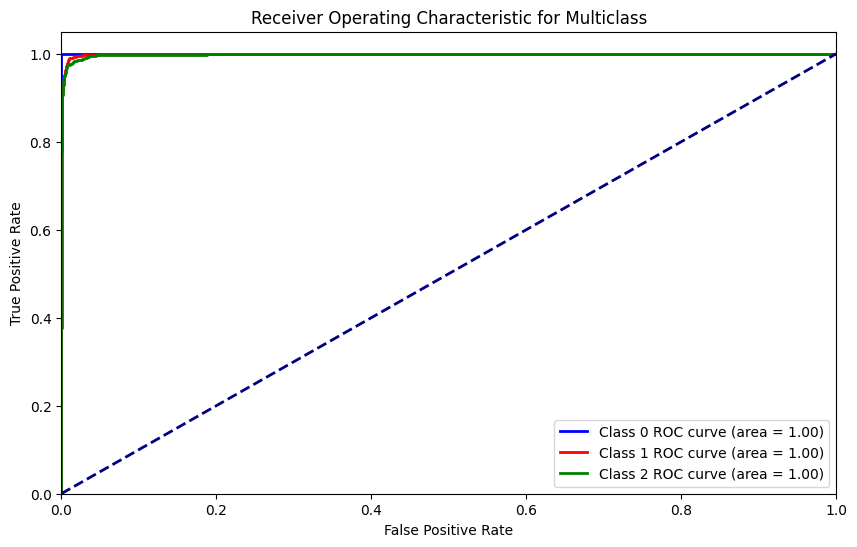

Computing Classification Metrics (Accuracy, Precision, Recall, Confusion Matrix)...
Confusion Matrix:
[[1633    0    1]
 [   0 1577   33]
 [   0   27 1559]]


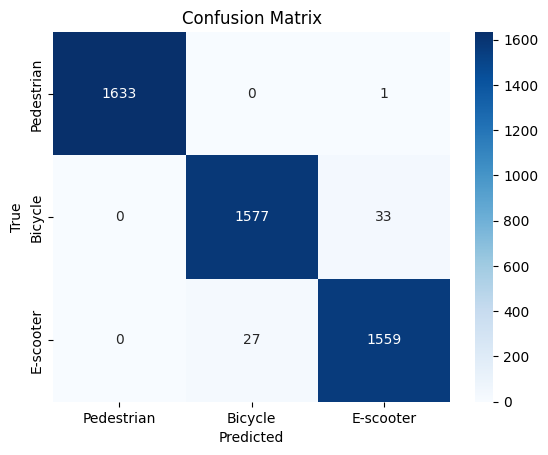

Computing Mean Average Precision (mAP)...
Accuracy: 0.9874
Precision (weighted): 0.9874
Recall (weighted): 0.9874
Mean Average Precision (mAP): 0.9982


In [15]:
test_model(model, test_loader, device)

In [16]:
# Phase 2: Fine-tuning with unfreezing all layers
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers for fine-tuning

# Redefine optimizer with a lower learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Fine-tuning Phase 2 Training (15 epochs)
model, train_losses, val_losses, train_accs, val_accs = train_and_validate_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5  # Phase 2: 5 epochs
)

Epoch 1/5
----------
Epoch 1, Step 0/705, Time/Step: 0.00s, Loss: 0.0001, Accuracy: 1.0000
Epoch 1, Step 100/705, Time/Step: 0.41s, Loss: 0.0013, Accuracy: 0.9957
Epoch 1, Step 200/705, Time/Step: 0.83s, Loss: 0.0001, Accuracy: 0.9930
Epoch 1, Step 300/705, Time/Step: 1.25s, Loss: 0.0147, Accuracy: 0.9914
Epoch 1, Step 400/705, Time/Step: 1.66s, Loss: 0.3794, Accuracy: 0.9913
Epoch 1, Step 500/705, Time/Step: 2.07s, Loss: 0.0178, Accuracy: 0.9915
Epoch 1, Step 600/705, Time/Step: 2.49s, Loss: 0.0485, Accuracy: 0.9916
Epoch 1, Step 700/705, Time/Step: 2.91s, Loss: 0.0038, Accuracy: 0.9919
Train Loss: 0.0246 Accuracy: 0.9920
Epoch 1, Step 0/151, Time/Step: 2.93s, Loss: 0.0020, Accuracy: 1.0000
Epoch 1, Step 100/151, Time/Step: 3.29s, Loss: 0.0003, Accuracy: 0.9916
Val Loss: 0.0277 Accuracy: 0.9915
Epoch 1 completed in 347 seconds.
Epoch 2/5
----------
Epoch 2, Step 0/705, Time/Step: 0.00s, Loss: 0.0027, Accuracy: 1.0000
Epoch 2, Step 100/705, Time/Step: 0.43s, Loss: 0.0049, Accuracy: 0.9

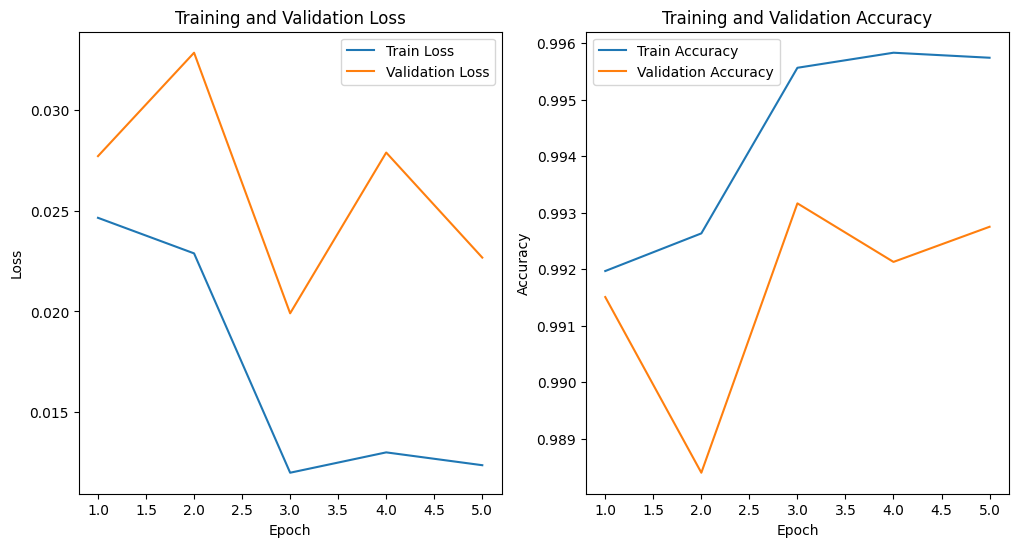

In [17]:
# Plot Training/Validation Loss and Accuracy for Fine-Tuning
plot_metrics(train_losses, val_losses, train_accs, val_accs)

# Save the best model
torch.save(model.state_dict(), 'fine_tuned_resnet18.pth')

## Step 3: Testing

Testing model...
Computing ROC Curve and AUC...


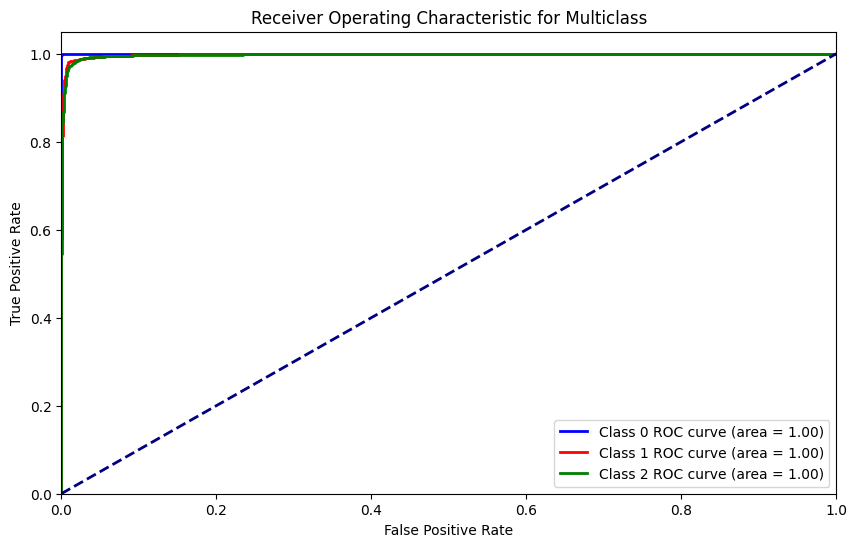

Computing Classification Metrics (Accuracy, Precision, Recall, Confusion Matrix)...
Confusion Matrix:
[[1633    0    1]
 [   0 1581   29]
 [   0   41 1545]]


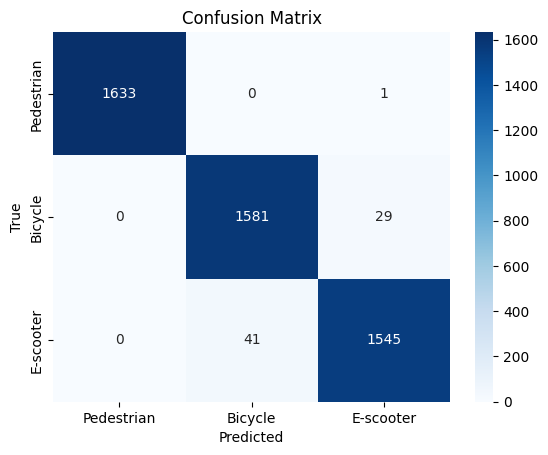

Computing Mean Average Precision (mAP)...
Accuracy: 0.9853
Precision (weighted): 0.9853
Recall (weighted): 0.9853
Mean Average Precision (mAP): 0.9970


In [18]:
test_model(model, test_loader, device)

## Step 4: Pruning

In [19]:
import torch.nn.utils.prune as prune
import os

# Function to check sparsity of pruned model
def check_sparsity(model):
    total_params = 0
    total_zero_params = 0
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total_params += module.weight.nelement()
            total_zero_params += (module.weight == 0).sum().item()

    sparsity = total_zero_params / total_params * 100
    print(f"Model Sparsity: {sparsity:.2f}%")
    return sparsity

# Function to print zero weights per layer
def print_zero_weights_per_layer(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            zero_weights = (module.weight == 0).sum().item()
            total_weights = module.weight.nelement()
            print(f'{name} - Zero Weights: {zero_weights}/{total_weights} ({zero_weights/total_weights*100:.2f}%)')

# Load the pre-trained ResNet18 model with the same settings as initial training
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.15),  # 15% dropout rate
    nn.Linear(num_features, 3)
)

# Load the fine-tuned state dictionary
model.load_state_dict(torch.load('/kaggle/working/fine_tuned_resnet18.pth'))

# Move the model to evaluation mode
model.eval()

# Function to prune the model and save both architecture and weights
def prune_and_save(model, amount, device, save_path):
    # Create a copy of the model to avoid altering the original
    pruned_model = copy.deepcopy(model)
    pruned_model.to(device)
    
    # Apply pruning to each applicable layer (Conv2d and Linear)
    for module in pruned_model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, 'weight')  # Make pruning permanent
    
    # Check sparsity after pruning
    check_sparsity(pruned_model)
    
    # Print zero weights per layer
    print_zero_weights_per_layer(pruned_model)
    
    # Save the entire model (including architecture and weights)
    torch.save(pruned_model, save_path)
    print(f'Pruned model with {amount*100:.0f}% sparsity saved at {save_path}')

# List of pruning thresholds to apply
pruning_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prune and save models at each threshold
for amount in pruning_thresholds:
    save_path = f'pruned_model_{int(amount*100)}.pth'
    prune_and_save(model, amount, device, save_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_30/2963910056.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Model Sparsity: 10.00%
conv1 - Zero Weights: 941/9408 (10.00%)
layer1.0.conv1 - Zero Weights: 3686/36864 (10.00%)
layer1.0.conv2 - Zero Weights: 3686/36864 (10.00%)
layer1.1.conv1 - Zero Weights: 3686/36864 (10.00%)
layer1.1.conv2 - Zero Weights: 3686/36864 (10.00%)
layer2.0.conv1 - Zero Weights: 7373/73728 (10.00%)
layer2.0.conv2 - Zero Weights: 14746/147456 (10.00%)
layer2.0.downsample.0 - Zero Weights: 819/8192 (10.00%)
layer2.1.conv1 - Zero Weights: 14746/147456 (10.00%)
layer2.1.conv2 - Zero Weights: 14746/147456 (10.00%)
layer3.0.conv1 - Zero Weights: 29491/294912 (10.00%)
layer3.0.conv2 - Zero Weights: 58982/589824 (10.00%)
layer3.0.downsample.0 - Zero Weights: 3277/32768 (10.00%)
layer3.1.conv1 - Zero Weights: 58982/589824 (10.00%)
layer3.1.conv2 - Zero Weights: 58982/589824 (10.00%)
layer4.0.conv1 - Zero Weights: 117965/1179648 (10.00%)
layer4.0.conv2 - Zero Weights: 235930/2359296 (10.00%)
layer4.0.downsample.0 - Zero Weights: 13107/131072 (10.00%)
layer4.1.conv1 - Zero Weigh

Loading model from: pruned_model_10.pth


/tmp/ipykernel_30/1515847513.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Confusion Matrix:
[[1633    0    1]
 [   0 1581   29]
 [   1   38 1547]]


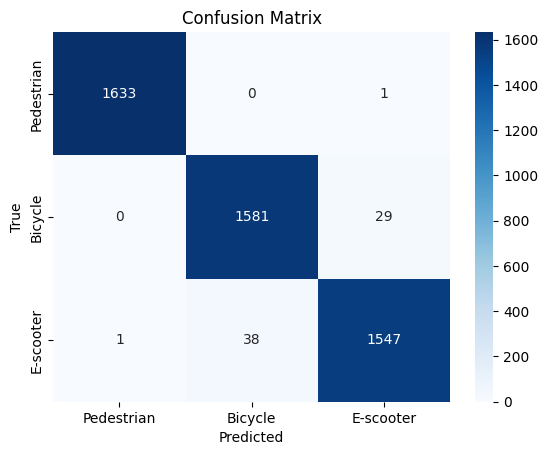

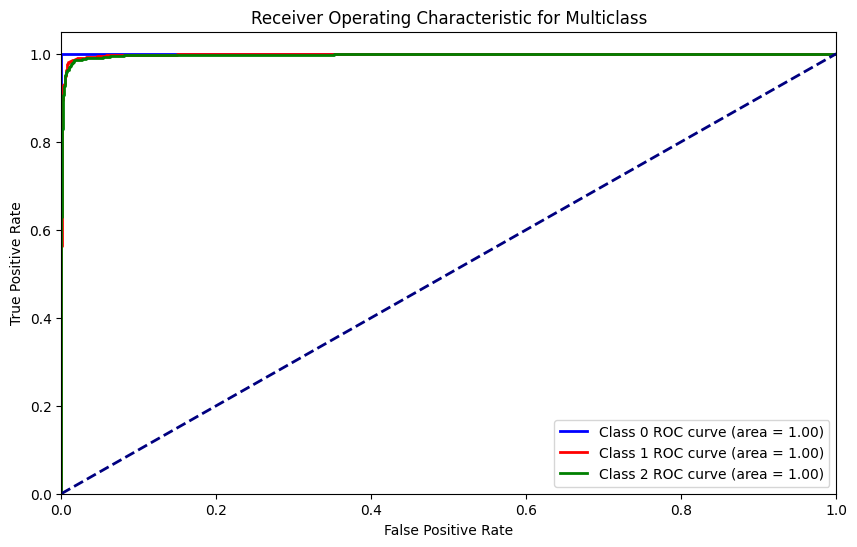

Loading model from: pruned_model_20.pth


/tmp/ipykernel_30/1515847513.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Confusion Matrix:
[[1633    0    1]
 [   0 1585   25]
 [   0   41 1545]]


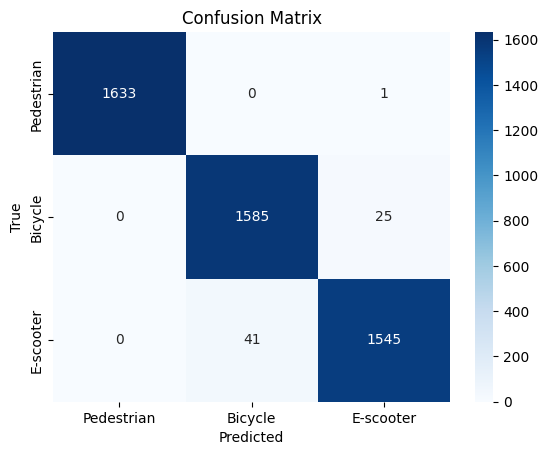

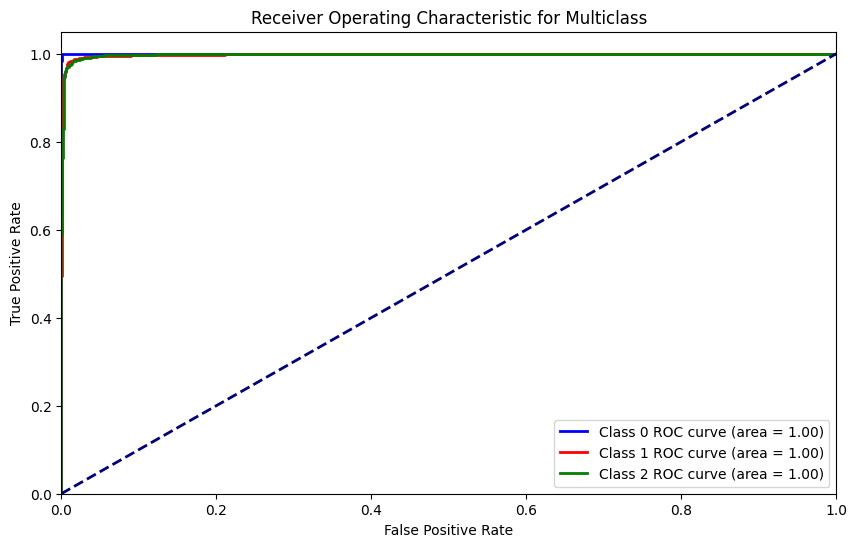

Loading model from: pruned_model_30.pth


/tmp/ipykernel_30/1515847513.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Confusion Matrix:
[[1630    0    4]
 [   0 1582   28]
 [   0   42 1544]]


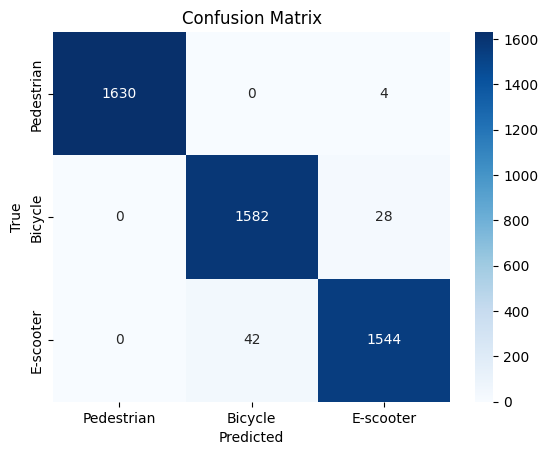

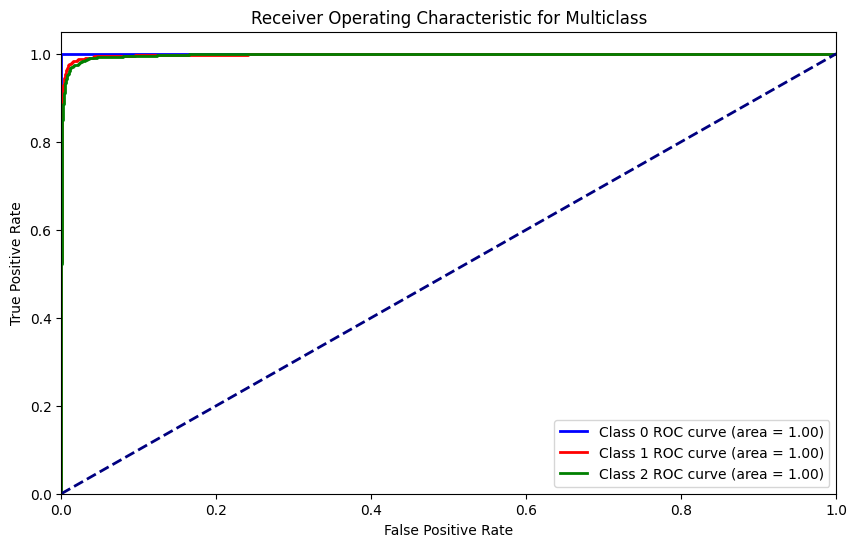

Loading model from: pruned_model_40.pth


/tmp/ipykernel_30/1515847513.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Confusion Matrix:
[[1630    0    4]
 [   0 1581   29]
 [   1   50 1535]]


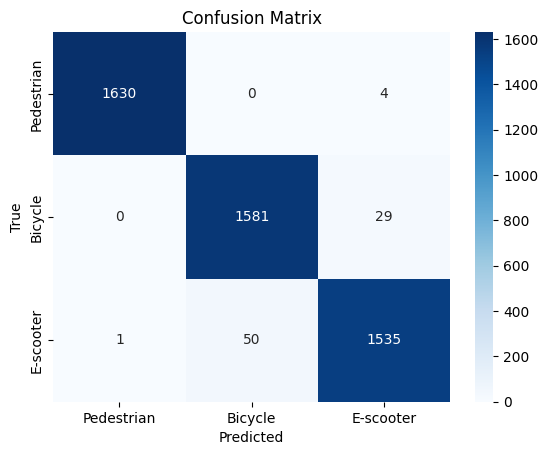

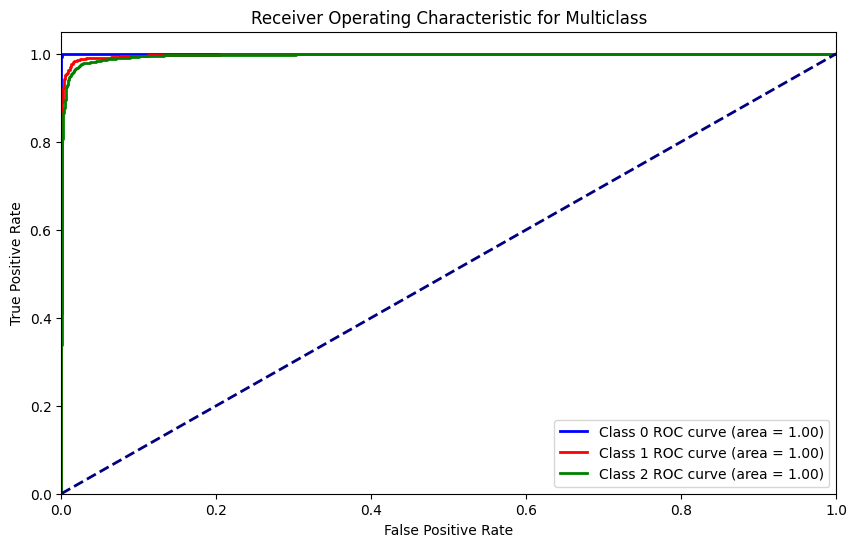

Loading model from: pruned_model_50.pth


/tmp/ipykernel_30/1515847513.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Confusion Matrix:
[[1595    0   39]
 [   1 1543   66]
 [   0   28 1558]]


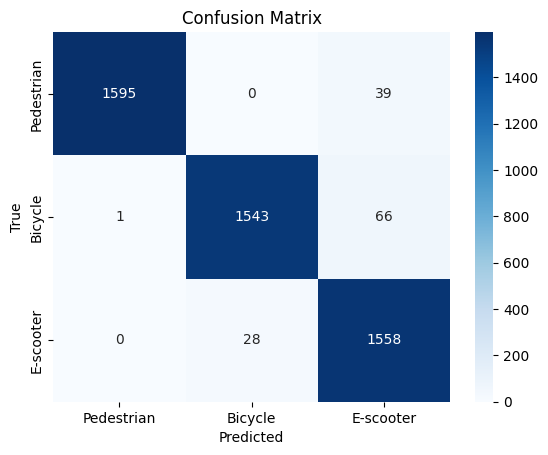

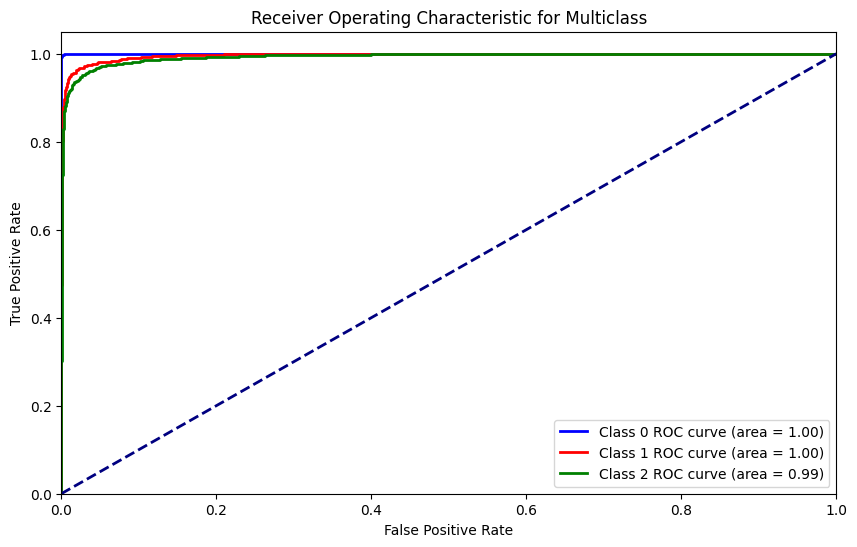

Result Summary
   Pruning Threshold (%)  Accuracy  Precision    Recall  \
0                     10  0.985714   0.985723  0.985714   
1                     20  0.986128   0.986160  0.986128   
2                     30  0.984679   0.984712  0.984679   
3                     40  0.982609   0.982663  0.982609   
4                     50  0.972257   0.973114  0.972257   

   Mean Average Precision (mAP)  Average ROC AUC  
0                      0.997077         0.998680  
1                      0.996709         0.998758  
2                      0.996608         0.998479  
3                      0.996329         0.997882  
4                      0.993173         0.996369  


In [17]:
import pandas as pd
from torchinfo import summary
import seaborn as sns
import os

# Function to compute model size in MB
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / (1024 * 1024)
    os.remove("temp.pth")
    return size_mb

# Load and evaluate each pruned model
pruning_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for amount in pruning_thresholds:
    # Load the pruned model
    model_path = f'pruned_model_{int(amount*100)}.pth'
    print(f'Loading model from: {model_path}')
    model = torch.load(model_path)
    model = model.to(device)

    # Get model size and parameter count
    model_size = get_model_size(model)
    params_info = summary(model, verbose=0)
    num_params = params_info.total_params

    # Compute metrics using your test functions
    accuracy, precision, recall = compute_classification_metrics(model, test_loader, device)
    map_score = compute_map(model, test_loader, device)
    _, _, roc_auc = compute_roc_auc(model, test_loader, device)

    # Collect AUC scores (average AUC for multiclass)
    avg_auc = np.mean(list(roc_auc.values()))

    # Store results
    results.append({
        'Pruning Threshold (%)': int(amount * 100),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Mean Average Precision (mAP)': map_score,
        'Average ROC AUC': avg_auc
    })

# Create a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the table
print("Result Summary")
print(results_df)

# Save the results to a CSV file for further analysis if needed
results_df.to_csv('pruned_model_comparison.csv', index=False)

In [19]:
import torch
import pandas as pd
import os

# Function to count non-zero parameters and total parameters
def count_non_zero_params(model):
    non_zero_count = 0
    total_count = 0
    for param in model.parameters():
        total_count += param.numel()
        non_zero_count += torch.count_nonzero(param).item()
    return non_zero_count, total_count

# Load the existing DataFrame
results_df = pd.read_csv('pruned_model_comparison.csv')

# List of model file paths (ensure the paths match the pruning threshold in the DataFrame)
model_paths = {
    10: 'pruned_model_10.pth',
    20: 'pruned_model_20.pth',
    30: 'pruned_model_30.pth',
    40: 'pruned_model_40.pth',
    50: 'pruned_model_50.pth'
}

# Iterate over each row in the DataFrame to load and analyze the corresponding model
for index, row in results_df.iterrows():
    threshold = row['Pruning Threshold (%)']
    model_path = model_paths.get(threshold)

    if model_path and os.path.exists(model_path):
        # Load the pruned model
        model = torch.load(model_path)
        model.eval()

        # Count non-zero and total parameters
        non_zero_params, total_params = count_non_zero_params(model)

        # Get model size in MB
        model_size_mb = os.path.getsize(model_path) / (1024 ** 2)

        # Update the DataFrame with new information
        results_df.at[index, 'Non-zero Parameters'] = non_zero_params
        results_df.at[index, 'Total Parameters'] = total_params
    else:
        print(f"Model file for {threshold}% pruning does not exist.")

# Print the updated DataFrame
print(results_df)

# Save the updated DataFrame to a CSV file
results_df.to_csv('pruned_model_comparison_updated.csv', index=False)

/tmp/ipykernel_30/1291892025.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
/tmp/ipykernel_30/1291892025.py:33: FutureWarning: You are u

   Pruning Threshold (%)  Accuracy  Precision    Recall  \
0                     10  0.985714   0.985723  0.985714   
1                     20  0.986128   0.986160  0.986128   
2                     30  0.984679   0.984712  0.984679   
3                     40  0.982609   0.982663  0.982609   
4                     50  0.972257   0.973114  0.972257   

   Mean Average Precision (mAP)  Average ROC AUC  Non-zero Parameters  \
0                      0.997077         0.998680           10061206.0   
1                      0.996709         0.998758            8944361.0   
2                      0.996608         0.998479            7827517.0   
3                      0.996329         0.997882            6710672.0   
4                      0.993173         0.996369            5593827.0   

   Total Parameters  
0        11178051.0  
1        11178051.0  
2        11178051.0  
3        11178051.0  
4        11178051.0  
